In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import wilcoxon  # must import explicitly
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

## Helper functions

In [2]:
def diff_percent(Dm,AAA):
    return 100*((Dm-AAA)/AAA)

print(diff_percent(105.0,100.0))

5.0


In [3]:
def my_wilcox(data):                    # helper function to return p-value, pass difference data as series from dataframe
    z_stat, p_val = wilcoxon(data)   # if only 1 value passed
    #z_stat, p_val = wilcoxon(data.as_matrix())   # if only 1 value passed
    return p_val

In [4]:
my_wilcox([1,2,3,4,6,7,2,352,3])

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


0.0075792819433897285

In [5]:
def bland_altman_plot(data1, data2, structure, metric, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    z_stat, p_val = wilcoxon(data1, data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='red', linestyle='-')
    plt.axhline(md + 1.96*sd, color='blue', linestyle='--')
    plt.axhline(md - 1.96*sd, color='blue', linestyle='--')
    plt.xlabel('Dose (Gy)')
    plt.ylabel('Difference Gy')
    plt.title( str(np.round(md, decimals = 3)) + ' Gy mean difference with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    plt.savefig('BA.png')

In [6]:
def query_data(df, Col, structure, metric):   # helper function to get data, Col = AAA, AXB or diff
    return df[Col][(df['structure'] == structure) & (df['metric'] == metric)]

# Start analysis

In [7]:
HN_df = pd.read_csv('HN_df_clean_28_11.csv')  # read in the cleaned data

In [8]:
HN_df['Dm-AAA'] = HN_df['Dm'] - HN_df['AAA'] # get abs diff

In [9]:
HN_df['Dm-AAA%'] = diff_percent(HN_df['Dm'], HN_df['AAA'])

In [10]:
HN_df.head()

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA%
0,Case1,PTV2,D2%,65.392496,64.671451,-0.721045,-1.102642
1,Case1,PTV2,D5%,61.221910,60.574434,-0.647476,-1.057589
2,Case1,PTV2,D50%,56.935482,56.306392,-0.629090,-1.104918
3,Case1,PTV2,D95%,52.908380,53.783883,0.875503,1.654753
4,Case1,PTV2,D99%,38.261698,45.021250,6.759552,17.666628


In [11]:
HN_sub_df = HN_df[['Case', 'structure', 'metric', 'Dm-AAA%']]
HN_sub_df.head()

,Case,structure,metric,Dm-AAA%
0,Case1,PTV2,D2%,-1.102642
1,Case1,PTV2,D5%,-1.057589
2,Case1,PTV2,D50%,-1.104918
3,Case1,PTV2,D95%,1.654753
4,Case1,PTV2,D99%,17.666628


In [12]:
HN_sub_df['structure'].unique()

array(['PTV2', 'PTV1', 'Body', 'R Parotid', 'L Parotid', 'Brain Stem',
       'Spinal Cord', 'CTV65'], dtype=object)

Everything imported OK

## Get mean dose differences

In [13]:
mean_diff_table = HN_sub_df.groupby(['structure', 'metric'],as_index=False).mean().pivot(index='structure', columns='metric', values='Dm-AAA%') 

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\colors.py:954: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


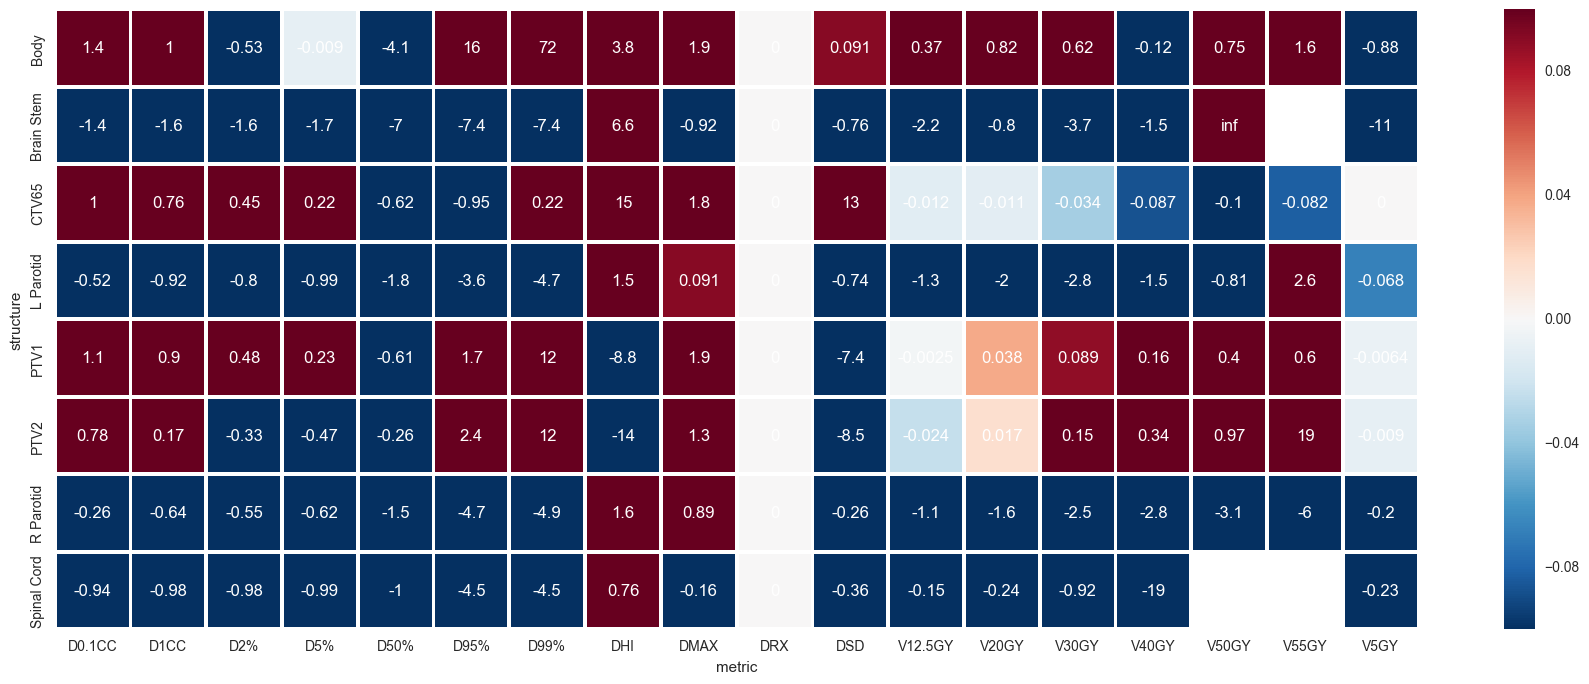

In [14]:
plt.figure(figsize=(22, 8))
ax1 = sns.heatmap(mean_diff_table, annot=True, linewidths=2.0, cbar=True)

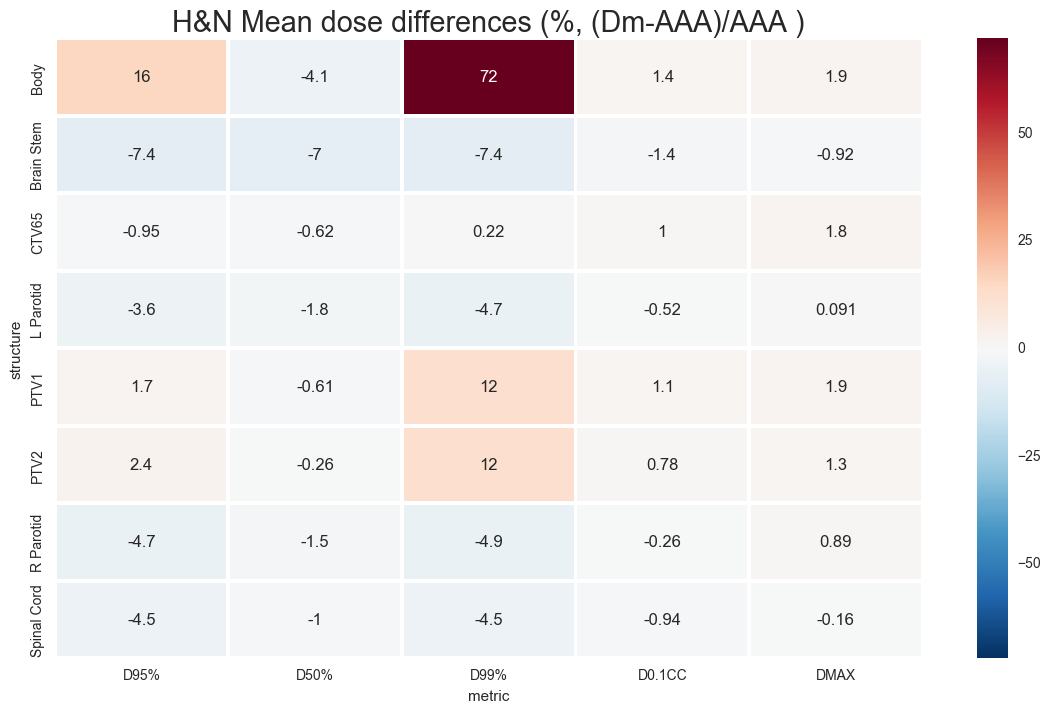

In [15]:
metrics_of_interest = [ 'D95%', 'D50%', 'D99%', 'D0.1CC', 'DMAX']
plt.figure(figsize=(14, 8))
ax1 = sns.heatmap(mean_diff_table[metrics_of_interest], annot=True, linewidths=2.0, cbar=True)
ax1.set_title('H&N Mean dose differences (%, (Dm-AAA)/AAA )', size='xx-large')
plt.savefig('H&N Mean dose difference.png', dpi=200)

## Get wilcoxon p value of differences

In [16]:
structures_of_interest = HN_sub_df['structure'].unique()

In [17]:
structures_of_interest

array(['PTV2', 'PTV1', 'Body', 'R Parotid', 'L Parotid', 'Brain Stem',
       'Spinal Cord', 'CTV65'], dtype=object)

In [18]:
i = len(structures_of_interest)
j = len(metrics_of_interest)
wilcox_data = np.zeros((i,j))  # init an empty array

In [19]:
d = HN_df  # for convenience just copy

j = 0
for structure in structures_of_interest:
    i = 0
    for metric in metrics_of_interest:
        A =  d[(d['structure'] == structure) & (d['metric'] == metric)]
        D =  A['Dm-AAA%']
        wilcox_data[j][i] = my_wilcox(D.values)
        i = i + 1
    j = j+ 1  

In [20]:
wilcox_data_df = pd.DataFrame(data=wilcox_data,    # values
...              index=structures_of_interest,    # 1st column as index
...              columns=metrics_of_interest)  # 1st row as the column names

In [21]:
wilcox_data_df

,D95%,D50%,D99%,D0.1CC,DMAX
PTV2,0.059336,0.139414,0.006910,0.332880,0.059336
PTV1,0.332880,0.074462,0.046853,0.009344,0.028417
Body,0.021824,0.021824,0.006910,0.006910,0.028417
R Parotid,0.012515,0.016605,0.012515,0.114128,0.646462
L Parotid,0.016605,0.005062,0.006910,0.092601,0.386271
Brain Stem,0.006910,0.005062,0.006910,0.059336,0.139414
Spinal Cord,0.028417,0.021824,0.016605,0.074462,0.646462
CTV65,0.092601,0.074462,0.646462,0.036658,0.016605


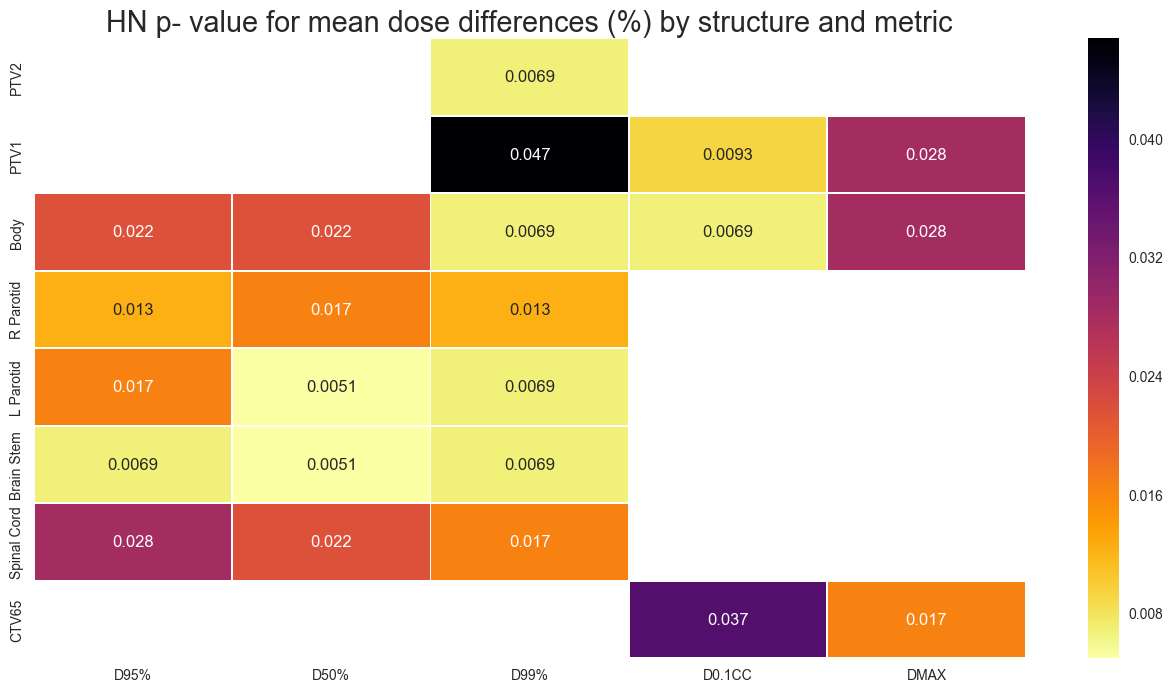

In [22]:
confidence = 0.05
plt.figure(figsize=(16, 8))
ax2 = sns.heatmap(wilcox_data_df[wilcox_data_df<confidence], annot=True, linewidths=.5,  cbar=True, cmap='inferno_r')
ax2.set_title('HN p- value for mean dose differences (%) by structure and metric', size='xx-large')
plt.savefig('HN p value for mean dose differences.png', dpi=500)

In [23]:
sub_diff_table = mean_diff_table[metrics_of_interest].loc[structures_of_interest]

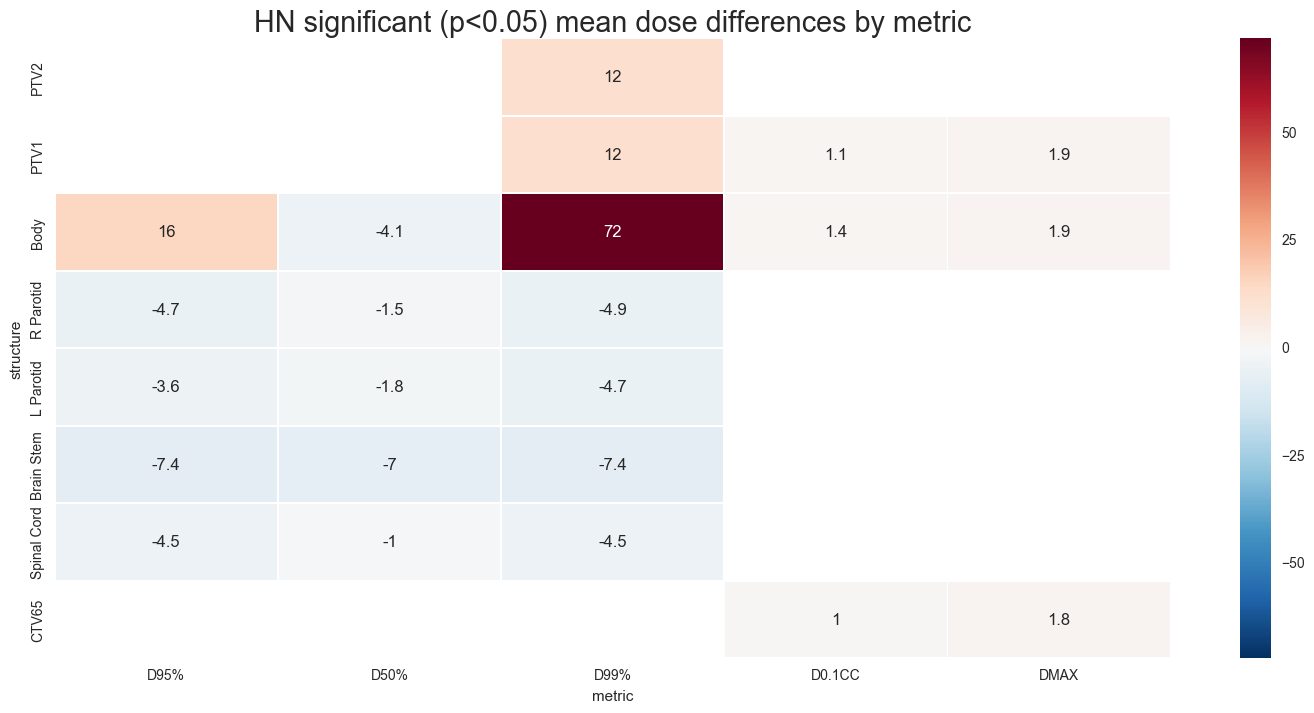

In [24]:
plt.figure(figsize=(18, 8)) 
data = sub_diff_table[wilcox_data_df<0.05]
mask = np.zeros_like(data, dtype=np.bool)   # create a mask 
mask[np.triu_indices_from(mask)] = True

ax3 = sns.heatmap(data, annot=True, linewidths=.5, center=0) #  mask=mask,
ax3.set_title('HN significant (p<0.05) mean dose differences by metric', size='xx-large')
plt.savefig('HN significant mean dose differences by metric.png', dpi=500)

# Investigate differences 

### PTV1 DMAX

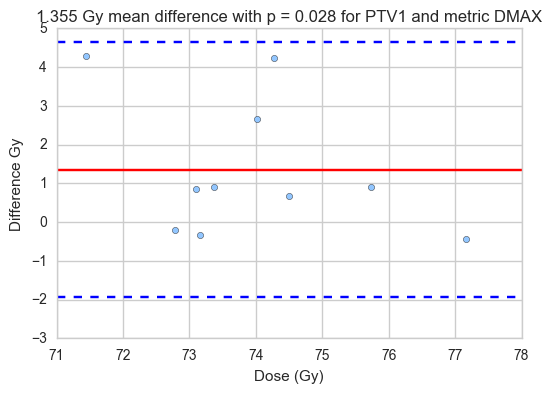

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA%
25,Case1,PTV1,DMAX,73.32000,72.99500,-0.32500,-0.443262
169,Case2,PTV1,DMAX,75.28158,76.19172,0.91014,1.208981
313,Case3,PTV1,DMAX,74.16500,74.83000,0.66500,0.896649
457,Case4,PTV1,DMAX,72.92000,73.83500,0.91500,1.254800
583,Case5,PTV1,DMAX,77.39100,76.94400,-0.44700,-0.577587
745,Case6,PTV1,DMAX,72.16110,76.38675,4.22565,5.855856
979,Case7,PTV1,DMAX,69.30066,73.59132,4.29066,6.191370
1033,Case8,PTV1,DMAX,72.68118,73.52631,0.84513,1.162791
1267,Case9,PTV1,DMAX,72.68118,75.34659,2.66541,3.667263
1411,Case10,PTV1,DMAX,72.87621,72.68118,-0.19503,-0.267618


In [25]:
structure = 'PTV1'
metric = 'DMAX'
plt.figure(figsize=(6, 4)) 
bland_altman_plot(query_data(HN_df, 'Dm', structure, metric), query_data(HN_df, 'AAA',structure, metric), structure, metric)
plt.show()
HN_df[(HN_df['structure'] == structure) & (HN_df['metric'] == metric)]

### Brain stem D50%

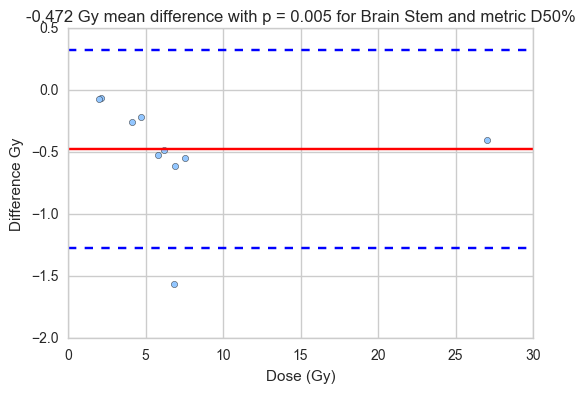

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA%
92,Case1,Brain Stem,D50%,27.252817,26.854172,-0.398645,-1.462765
236,Case2,Brain Stem,D50%,2.143964,2.082395,-0.061569,-2.871744
380,Case3,Brain Stem,D50%,4.236256,3.983629,-0.252627,-5.963459
506,Case4,Brain Stem,D50%,6.073990,5.556459,-0.517532,-8.520461
686,Case5,Brain Stem,D50%,2.046338,1.974176,-0.072162,-3.526414
830,Case6,Brain Stem,D50%,4.792651,4.578888,-0.213763,-4.460219
920,Case7,Brain Stem,D50%,7.637237,6.071817,-1.565420,-20.497204
1064,Case8,Brain Stem,D50%,6.425576,5.942164,-0.483412,-7.523243
1172,Case9,Brain Stem,D50%,7.804884,7.261682,-0.543202,-6.959772
1370,Case10,Brain Stem,D50%,7.165912,6.556099,-0.609812,-8.509905


In [26]:
structure = 'Brain Stem'
metric = 'D50%'
plt.figure(figsize=(6, 4)) 
bland_altman_plot(query_data(HN_df, 'Dm', structure, metric), query_data(HN_df, 'AAA',structure, metric), structure, metric)
plt.show()
HN_df[(HN_df['structure'] == structure) & (HN_df['metric'] == metric)]

# Case 7

In [31]:
HN_df[(HN_df['Case'] == 'Case7') & (HN_df['metric'] == 'DMAX')]

,Case,structure,metric,AAA,Dm,Dm-AAA,Dm-AAA%
871,Case7,CTV65,DMAX,69.30066,73.59132,4.29066,6.191370
889,Case7,L Parotid,DMAX,57.79389,60.52431,2.73042,4.724409
907,Case7,R Parotid,DMAX,68.45553,73.26627,4.81074,7.027540
925,Case7,Brain Stem,DMAX,48.95253,50.64279,1.69026,3.452855
943,Case7,Spinal Cord,DMAX,46.09209,47.39229,1.30020,2.820874
961,Case7,Body,DMAX,69.30066,73.59132,4.29066,6.191370
979,Case7,PTV1,DMAX,69.30066,73.59132,4.29066,6.191370
997,Case7,PTV2,DMAX,68.13048,72.68118,4.55070,6.679389


In [36]:
from pyEclipseDVH import eclipse_DVH

In [40]:
Case7_AAA = eclipse_DVH('Case7_AAA.txt')
Case7_Dm = eclipse_DVH('Case7_Dm.txt')

Case7_AAA.txt loaded 	 patID = Case7_AAA	 Prescription [Gy] = 65.010
Case7_Dm.txt loaded 	 patID = Case7_Dm	 Prescription [Gy] = 65.010


In [41]:
Case7_AAA.DVH_df.columns

Index(['Artifact', 'GTV', 'GTVn', 'GTV + 15mm', 'GTVn + 10mm', 'CTV65',
       'CTV54', 'L Parotid', 'R Parotid', 'L Lens', 'R Lens', 'L Orbit',
       'R Orbit', 'Brain Stem', 'Spinal Cord', 'BS + 3mm', 'BS + 5mm', 'Body',
       'Lt Par edit', 'PTV1', 'PTV1 edit', 'PTV2', 'PTV2 edit',
       'Pseudo Midline', 'Pseudo Oral Cav', 'Pseudo PostBrain', 'Pseudo Post',
       'Rt Par edit', 'SC + 3mm', 'SC + 5mm', 'Pseudo PTV1', 'Pseudo PTV2',
       'Left Couch Bar', 'Right Couch Bar', 'Annulus1', 'Dose 6175[cGy]',
       'Dose 5130[cGy]', 'missing1', 'missing2'],
      dtype='object')

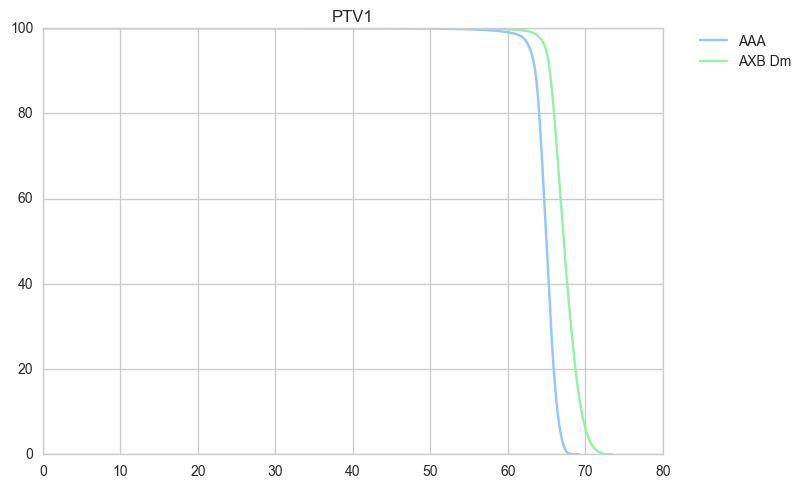

In [42]:
structure = 'PTV1'
plt.plot(Case7_AAA.DVH_df[structure], label="AAA")
plt.plot(Case7_Dm.DVH_df[structure], label="AXB Dm")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(structure)